In [1]:
#Astropy
import astropy
from astropy.io import fits
from astropy.table import Table

# Matplotlib
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline
matplotlib.rcParams.update({'font.size': 25})

#Numpy/Scipy
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
from scipy.optimize import curve_fit
from scipy.stats import binned_statistic_2d

In [2]:
leff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757}
def ccm_a(x):
    '''
    a(x) function from Cardelli et al. 1989
    
    Input:
    -----
        x: effective wavelength in units of 1/micron
        
    Output:
    ------
        a: a function value  
    '''
    if 0.3 <= x < 1.1:
        a = 0.574*(x**1.61)
        return a
    
    elif 1.1 <= x < 3.3:
        y = x - 1.82
        a = (1.+0.17699*y-0.50477*(y**2)-0.02427*(y**3)+0.72085*(y**4)+
                0.01979*(y**5)-0.77530*(y**6)+0.32999*(y**7))
        return a
    
    elif 3.3 <= x < 8.0:
        if x < 5.9:
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)
            return a
        
        else:
            fa = -0.04473*((x-5.9)**2)+0.1207*((x-5.9)**3)
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)+fa
            return a       
    
def ccm_b(x):
    '''
    b(x) function from Cardelli et al. 1989
    
    Input:
    -----
        x: effective wavelength in units of 1/micron
        
    Output:
    ------
        b: b function value 
    '''
    if 0.3 <= x < 1.1:
        b = -0.527*(x**1.61)
        return b
    
    elif 1.1 <= x <= 3.3:
        y = x - 1.82
        b = (1.41338*y+2.28305*(y**2)+1.07233*(y**3)-5.38434*(y**4)-
                0.62251*(y**5)+5.30260*(y**6)-2.09002*(y**7))
        return b
    
    elif 3.3 <= x < 8.0:
        if x < 5.9:
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)
            return b
        
        else:
            fb = 0.2130*((x-5.9)**2)+0.1207*((x-5.9)**3)
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)+fb
            return b
    
def ccm_alav(wave,rv):
    '''
    Calculate A\lambda/Av
    
    Inputs:
    ------
        wave: effective wavelength in units of micron
        rv: Rv value (=Av/E(B_V))
        
    Output:
    ------
        alav: A\lambda/Av
    '''
    x=1/wave
    alav = ccm_a(x)+ccm_b(x)/rv
    return alav

ejk_ak = (ccm_alav(leff['J'],3.1)-ccm_alav(leff['K'],3.1))/ccm_alav(leff['K'],3.1)
ebv_ak = (ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))/ccm_alav(leff['K'],3.1)

def closest(data,value):
    '''
    Find nearest value in array to given value
        
    Inputs:
    ------
        data: data to search through 
        value: value of interest
    '''
        
    data = np.asarray(data)
    return data[(np.abs(np.subtract(data,value))).argmin()]

def neighbors(data,value):
    '''
    Find values of two elements closest to the given value

    Inputs:
    ------
        data: data to search through 
        value: value of interest

    Output:
    ------
        close1: closest value under the given value
        close2: closest value over the given value
    '''

    data = np.asarray(data)
    close1 = data[(np.abs(np.subtract(data,value))).argmin()]
    data = data[np.where(data!=close1)]
    close2 = data[(np.abs(np.subtract(data,value))).argmin()]

    return close1,close2

def mad(dat):
    return np.nanmedian(np.abs(dat-np.nanmedian(dat)))

abp_ebv = ccm_alav(leff['BP'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
arp_ebv = ccm_alav(leff['RP'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
aj_ebv = ccm_alav(leff['J'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
ah_ebv = ccm_alav(leff['H'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
ak_ebv = ccm_alav(leff['K'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))

In [4]:
def upturn10Gyr(age):
    '''
    Boundary for 10 Gyr upturn in Aetas and APOKASC plot 
    
    Input:
    -----
        age: age in Gyr
        
    Output:
    ------
        ups: value on boundary 
    '''
    ups = np.ones(np.size(age))
    for i in range(np.size(age)):
        if age[i] <= 11:
            up = 11

        else:
            up = age[i]
            
        ups[i] = up

    return ups

def oldapokasc(age):
    '''
    Boundary for old stars in APOKASC given young age by Aetas
    
    Input:
    -----
        age: age in Gyr
    
    Output:
    ------
        olds: value on boundary
    '''
    olds = np.ones(np.size(age))
    for i in range(np.size(age)):
        olds[i] = age[i] - 4
        
    return olds

In [10]:
from scipy.optimize import curve_fit
from tqdm import tqdm_notebook

# PARSEC

In [6]:
massive = fits.getdata('/Users/joshuapovick/Desktop/Research/parsec/parsec_massive_lite.fits.gz')
massive = Table(massive[np.where(massive['label']==3.0)])
massive['index'] = np.arange(len(massive))
massive = massive[np.argsort(massive['logAge'])]
massive = massive['index','MH','Mass','logAge','logTe','logg','Gmag','G_BPmag','G_RPmag','Jmag','Hmag','Ksmag']

# APOGEE/APOKASC

<ipython-input-11-2ce71202d903>:29: RuntimeWarning: invalid value encountered in sqrt
  apoafe_err = np.sqrt(kdr17['ALPHA_M']**2+kdr17['M_H']**2-kdr17['FE_H']**2)


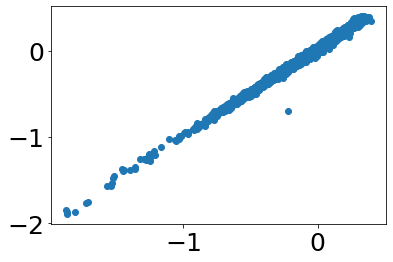

In [11]:
from astropy.io import ascii

kasc672 = fits.getdata('/Users/joshuapovick/Desktop/Research/APOKASC/APOKASC_cat_v6.7.2.fits.gz')
kasc3 = ascii.read('MLtesterr3bDR16A3PalphaM_july5.out')
dr17 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStar-dr17-synspec.fits.gz')

# xmatch APOKASC Catalogs
_, k672idx, k3idx = np.intersect1d(kasc672['2MASS_ID'],kasc3['2MASSID'],return_indices=True)
k672 = kasc672[k672idx]
k3 = kasc3[k3idx]

# xmatch APOKASC with DR17
_, k3idx, dr17idx = np.intersect1d(k3['2MASSID'],dr17['APOGEE_ID'],return_indices=True)

k672dr17 = k672[k3idx]
k3dr17 = k3[k3idx]
kdr17 = dr17[dr17idx]

# Select RGB stars
ageevs = np.where((k3dr17['IntAge']>-10.)&(k672dr17['APOKASC3_CONS_EVSTATES']==1.0)&
                  (kdr17['GAIAEDR3_PARALLAX']/kdr17['GAIAEDR3_PARALLAX_ERROR']>3.0))

k672dr17 = k672dr17[ageevs]
k3dr17 = k3dr17[ageevs]
kdr17 = kdr17[ageevs]

# [Alpha/Fe]
apoafe = kdr17['ALPHA_M']+kdr17['M_H']-kdr17['FE_H']
apoafe_err = np.sqrt(kdr17['ALPHA_M']**2+kdr17['M_H']**2-kdr17['FE_H']**2)

# Salaris correction 0.659, 0.341 from Asplund et al 2021.
salfeh = kdr17['FE_H']+np.log10(0.659*(10**(apoafe))+0.341)
salfeh_err = np.sqrt(kdr17['FE_H_ERR']**2+((1-0.341/(0.659*(10**(apoafe_err))+0.341))*apoafe)**2)

plt.scatter(kdr17['FE_H'],k3dr17['Fe/H'])

In [8]:
from scipy.stats import binned_statistic
gaiaedr3 = fits.getdata('/Users/joshuapovick/Desktop/Research/gaia/GAIAEDR3allStar.fits.gz')

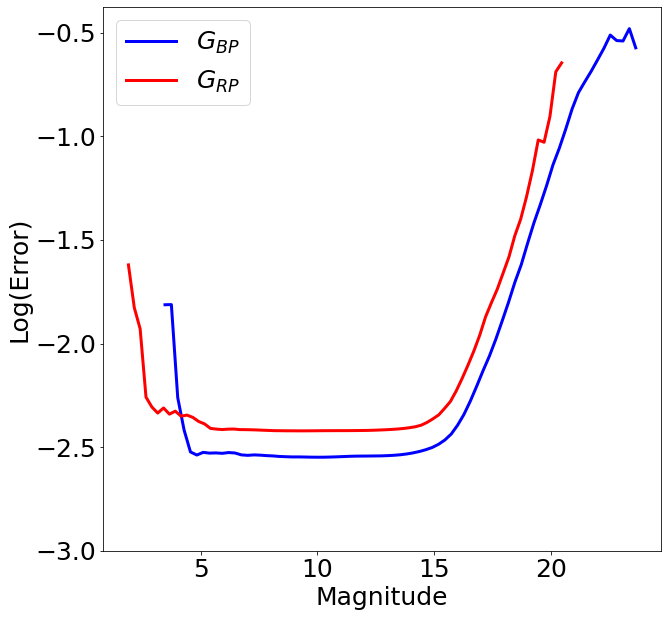

In [9]:
binnum = 75

### BP
bp_fin = np.where(np.isfinite(gaiaedr3['phot_bp_mean_mag'])==True)

bpmin = min(gaiaedr3['phot_bp_mean_mag'][bp_fin])
bpmax = max(gaiaedr3['phot_bp_mean_mag'][bp_fin])

bpdiff = bpmax-bpmin
bpfluxerr = (2.5*0.434)/gaiaedr3['phot_bp_mean_flux_over_error'][bp_fin]
bpmagerr = np.sqrt((bpfluxerr)**2+0.0027901700**2)

bpbin ,_,_ = binned_statistic(gaiaedr3['phot_bp_mean_mag'][bp_fin],np.log10(bpmagerr),'median',bins=binnum)

### RP 
rp_fin = np.where(np.isfinite(gaiaedr3['phot_rp_mean_mag'])==True)

rpmin = min(gaiaedr3['phot_rp_mean_mag'][rp_fin])
rpmax = max(gaiaedr3['phot_rp_mean_mag'][rp_fin])

rpdiff = rpmax-rpmin
rpfluxerr = (2.5*0.434)/gaiaedr3['phot_rp_mean_flux_over_error'][rp_fin]
rpmagerr = np.sqrt((rpfluxerr)**2+0.0037793818**2)

rpbin ,_,_ = binned_statistic(gaiaedr3['phot_rp_mean_mag'][rp_fin],np.log10(rpmagerr),'median',bins=binnum)

### Plot
plt.figure(figsize=[10,10])
plt.plot(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin,lw=3.0,c='blue',label=r'$G_{BP}$')
plt.plot(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin,lw=3.0,c='red',label=r'$G_{RP}$')
plt.legend()
plt.ylim(bottom=-3.0)
plt.xlabel('Magnitude')
plt.ylabel('Log(Error)');

bperrfunc = IUS(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin)
rperrfunc = IUS(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin)

bperr = 10**bperrfunc(kdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'])
rperr = 10**rperrfunc(kdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'])

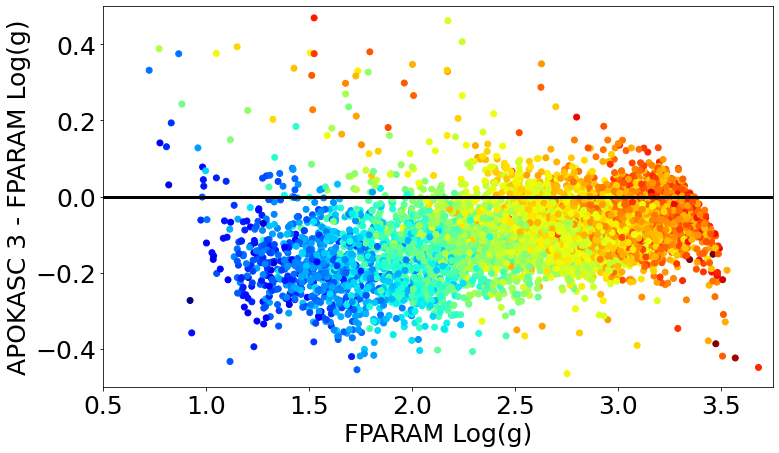

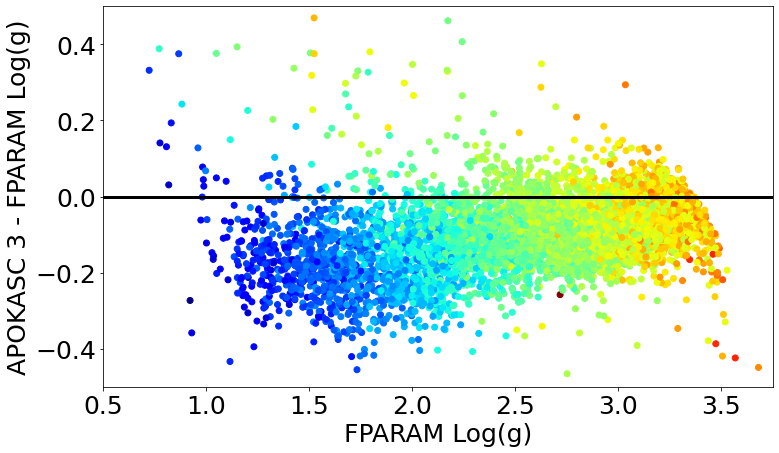

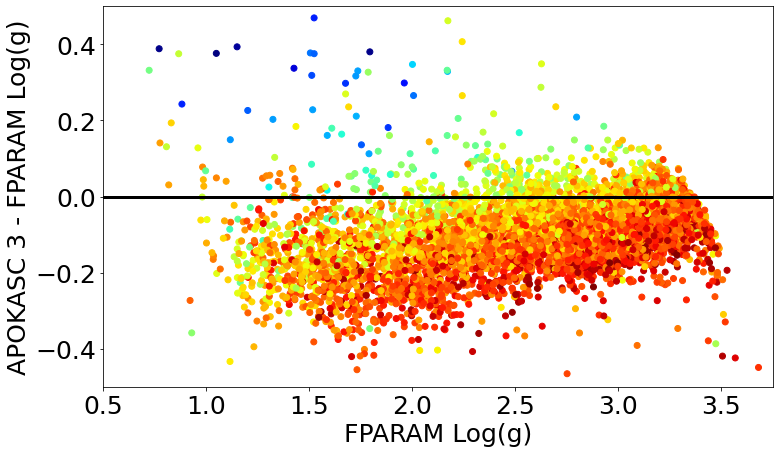

In [23]:
plt.figure(figsize=[12,7])
plt.scatter(kdr17['FPARAM'][:,1],k3dr17['Logg']-kdr17['FPARAM'][:,1],c=kdr17['TEFF'],cmap='jet')
plt.axhline(0.0,c='k',lw=3.0)
plt.xlabel(r'FPARAM Log(g)')
plt.ylabel(r'APOKASC 3 - FPARAM Log(g)')
plt.xlim(0.5,3.75)
plt.ylim(-0.5,0.5)
plt.show()

plt.figure(figsize=[12,7])
plt.scatter(kdr17['FPARAM'][:,1],k3dr17['Logg']-kdr17['FPARAM'][:,1],c=kdr17['FPARAM'][:,0],cmap='jet')
plt.axhline(0.0,c='k',lw=3.0)
plt.xlabel(r'FPARAM Log(g)')
plt.ylabel(r'APOKASC 3 - FPARAM Log(g)')
plt.xlim(0.5,3.75)
plt.ylim(-0.5,0.5)
plt.show()

plt.figure(figsize=[12,7])
plt.scatter(kdr17['FPARAM'][:,1],k3dr17['Logg']-kdr17['FPARAM'][:,1],c=kdr17['M_H'],cmap='jet')
plt.axhline(0.0,c='k',lw=3.0)
plt.xlabel(r'FPARAM Log(g)')
plt.ylabel(r'APOKASC 3 - FPARAM Log(g)')
plt.xlim(0.5,3.75)
plt.ylim(-0.5,0.5)
plt.show()

# Logg with [M/H] Calibration

In [26]:
cut = np.where((np.isfinite(kdr17['FPARAM'][:,1])==True)&(np.isfinite(k3dr17['Logg']-kdr17['FPARAM'][:,1])==True)&
               (np.isfinite(kdr17['M_H'])==True)&(np.isfinite(kdr17['TEFF'])==True)&(kdr17['STARFLAG']==0))

def logg_calib(X,a,b,c,d,e):
    '''
    Functional form of log(g) calibration for RGB stars in DR16 (see J\"{o}sson et al. 2020)
    '''
    grav, mets = X
    return a+b*grav+c*grav**2+d*grav**3+e*mets

param_labels = np.array(['a','b','c','d','e'])
popt_logg_calib, _ = curve_fit(logg_calib, (kdr17['FPARAM'][:,1][cut],kdr17['M_H'][cut]),
                               (k3dr17['Logg']-kdr17['FPARAM'][:,1])[cut])

print('Fit Parameters:')
for i in range(len(param_labels)):
    print(r'{} = {:.5f}'.format(param_labels[i],popt_logg_calib[i]))
    
logg_cal = kdr17['FPARAM'][:,1]+logg_calib(([kdr17['FPARAM'][:,1],kdr17['M_H']]),*popt_logg_calib)

Fit Parameters:
a = 0.82186
b = -1.45658
c = 0.65196
d = -0.08889
e = -0.19446


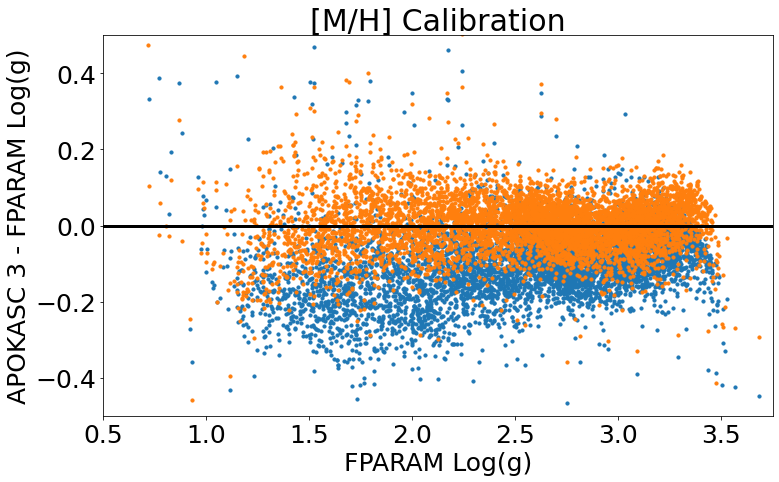

In [45]:
plt.figure(figsize=[12,7])
plt.scatter(kdr17['FPARAM'][:,1],k3dr17['Logg']-kdr17['FPARAM'][:,1],s=10)
plt.scatter(kdr17['FPARAM'][:,1],k3dr17['Logg']-logg_cal,s=10)
plt.axhline(0.0,c='k',lw=3.0)
plt.title(r'[M/H] Calibration')
plt.xlabel(r'FPARAM Log(g)')
plt.ylabel(r'APOKASC 3 - FPARAM Log(g)')
plt.xlim(0.5,3.75)
plt.ylim(-0.5,0.5)
plt.show()

# Logg with FPARAM TEFF Calibration

In [79]:
def logg_calib_fteff(X,a,b,c,d,e):
    '''
    Functional form of log(g) calibration for RGB stars in DR16 (see J\"{o}sson et al. 2020)
    '''
    grav, tefs = X
    return a+b*grav+c*grav**2+d*grav**3+e*tefs

param_labels = np.array(['a','b','c','d','e'])
popt_logg_calib_fteff, _ = curve_fit(logg_calib_fteff, (kdr17['FPARAM'][:,1][cut],kdr17['FPARAM'][:,0][cut]),
                               (k3dr17['Logg']-kdr17['FPARAM'][:,1])[cut])

print('Fit Parameters:')
for i in range(len(param_labels)):
    print(r'{} = {:.5f}'.format(param_labels[i],popt_logg_calib_fteff[i]))
    
logg_cal_fteff = kdr17['FPARAM'][:,1]+logg_calib_fteff(([kdr17['FPARAM'][:,1],kdr17['FPARAM'][:,0]]),*popt_logg_calib_fteff)

Fit Parameters:
a = -0.18289
b = -1.62334
c = 0.63707
d = -0.08643
e = 0.00033


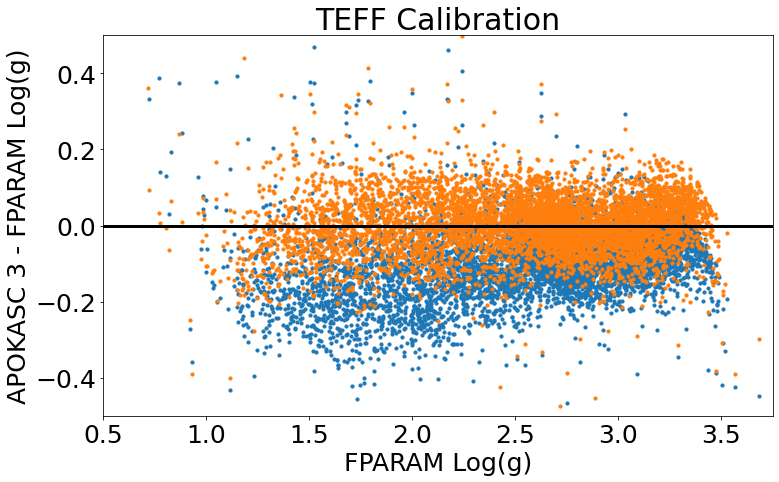

In [80]:
plt.figure(figsize=[12,7])
plt.scatter(kdr17['FPARAM'][:,1],k3dr17['Logg']-kdr17['FPARAM'][:,1],s=10)
plt.scatter(kdr17['FPARAM'][:,1],k3dr17['Logg']-logg_cal_fteff,s=10)
plt.axhline(0.0,c='k',lw=3.0)
plt.title(r'TEFF Calibration')
plt.xlabel(r'FPARAM Log(g)')
plt.ylabel(r'APOKASC 3 - FPARAM Log(g)')
plt.xlim(0.5,3.75)
plt.ylim(-0.5,0.5)
plt.show()

# Logg with FPARAM [ALPHA/M] Calibration

In [81]:
def logg_calib_falpha(X,a,b,c,d,e):
    '''
    Functional form of log(g) calibration for RGB stars in DR16 (see J\"{o}sson et al. 2020)
    '''
    grav, alfs = X
    return a+b*grav+c*grav**2+d*grav**3+e*alfs

param_labels = np.array(['a','b','c','d','e'])
popt_logg_calib_falpha, _ = curve_fit(logg_calib_falpha, (kdr17['FPARAM'][:,1][cut],kdr17['FPARAM'][:,-2][cut]),
                               (k3dr17['Logg']-kdr17['FPARAM'][:,1])[cut])

print('Fit Parameters:')
for i in range(len(param_labels)):
    print(r'{} = {:.5f}'.format(param_labels[i],popt_logg_calib_falpha[i]))
    
logg_cal_falpha = kdr17['FPARAM'][:,1]+logg_calib_falpha(([kdr17['FPARAM'][:,1],kdr17['FPARAM'][:,-2]]),
                                                         *popt_logg_calib_falpha)

Fit Parameters:
a = 0.62381
b = -1.50576
c = 0.66892
d = -0.09093
e = 0.54111


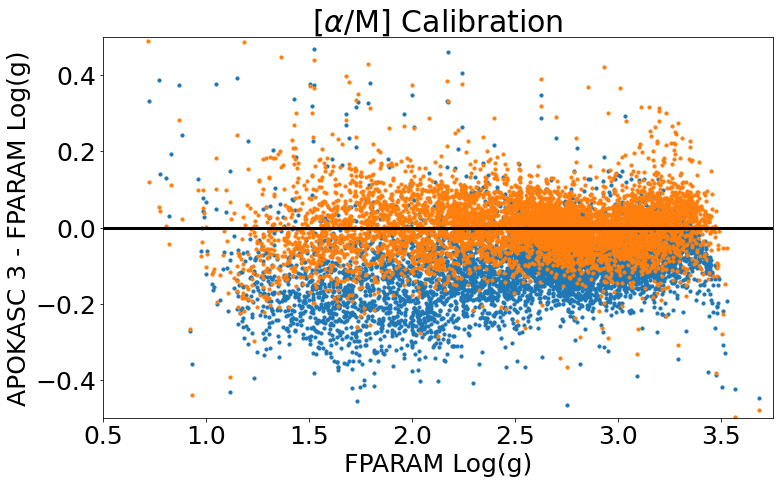

In [82]:
plt.figure(figsize=[12,7])
plt.scatter(kdr17['FPARAM'][:,1],k3dr17['Logg']-kdr17['FPARAM'][:,1],s=10)
plt.scatter(kdr17['FPARAM'][:,1],k3dr17['Logg']-logg_cal_falpha,s=10)
plt.axhline(0.0,c='k',lw=3.0)
plt.title(r'[$\alpha$/M] Calibration')
plt.xlabel(r'FPARAM Log(g)')
plt.ylabel(r'APOKASC 3 - FPARAM Log(g)')
plt.xlim(0.5,3.75)
plt.ylim(-0.5,0.5)
plt.show()

In [83]:
def logg_calib_falpha2(X,a,b,c,d,e,f):
    '''
    Functional form of log(g) calibration for RGB stars in DR16 (see J\"{o}sson et al. 2020)
    '''
    grav, alfs = X
    return a+b*grav+c*grav**2+d*grav**3+e*alfs+f*alfs**2

param_labels = np.array(['a','b','c','d','e','f'])
popt_logg_calib_falpha2, _ = curve_fit(logg_calib_falpha2, (kdr17['FPARAM'][:,1][cut],kdr17['FPARAM'][:,-2][cut]),
                               (k3dr17['Logg']-kdr17['FPARAM'][:,1])[cut])

print('Fit Parameters:')
for i in range(len(param_labels)):
    print(r'{} = {:.5f}'.format(param_labels[i],popt_logg_calib_falpha2[i]))
    
logg_cal_falpha2 = kdr17['FPARAM'][:,1]+logg_calib_falpha2(([kdr17['FPARAM'][:,1],kdr17['FPARAM'][:,-2]]),
                                                         *popt_logg_calib_falpha2)

Fit Parameters:
a = 1.03361
b = -1.52431
c = 0.69003
d = -0.09567
e = -1.11646
f = 1.61377


In [65]:
# plt.figure(figsize=[10,10])
# plt.scatter(logg_cal,logg_cal_fteff)
# plt.xlabel(r'Log(g) With [M/H] Calibration')
# plt.ylabel(r'Log(g) With FPARAM TEFF Calibration')

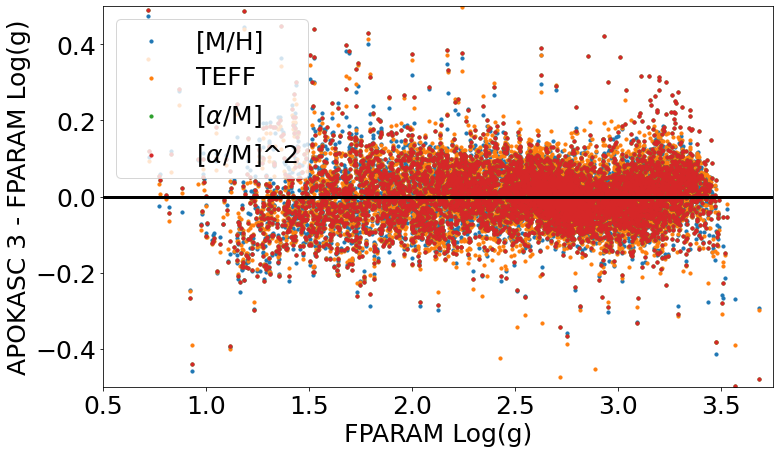

In [86]:
plt.figure(figsize=[12,7])
plt.scatter(kdr17['FPARAM'][:,1],k3dr17['Logg']-logg_cal,s=10,label='[M/H]')
plt.scatter(kdr17['FPARAM'][:,1],k3dr17['Logg']-logg_cal_fteff,s=10,label='TEFF')
plt.scatter(kdr17['FPARAM'][:,1],k3dr17['Logg']-logg_cal_falpha,s=10,label='[$\\alpha$/M]')
plt.scatter(kdr17['FPARAM'][:,1],k3dr17['Logg']-logg_cal_falpha,s=10,label='[$\\alpha$/M]^2')
plt.legend()
plt.axhline(0.0,c='k',lw=3.0)
plt.xlabel(r'FPARAM Log(g)')
plt.ylabel(r'APOKASC 3 - FPARAM Log(g)')
plt.xlim(0.5,3.75)
plt.ylim(-0.5,0.5)
plt.show()

In [87]:
print('Log(g) with [M/H] calibration')
print(np.nanmedian(k3dr17['Logg']-logg_cal))
print(mad(k3dr17['Logg']-logg_cal))

print('Log(g) with FPARAM TEFF calibration')
print(np.nanmedian(k3dr17['Logg']-logg_cal_fteff))
print(mad(k3dr17['Logg']-logg_cal_fteff))

print('Log(g) with FPARAM [alpha/M] calibration')
print(np.nanmedian(k3dr17['Logg']-logg_cal_falpha))
print(mad(k3dr17['Logg']-logg_cal_falpha))

print('Log(g) with FPARAM [alpha/M]^2 calibration')
print(np.nanmedian(k3dr17['Logg']-logg_cal_falpha2))
print(mad(k3dr17['Logg']-logg_cal_falpha2))

Log(g) with [M/H] calibration
0.0022199413299561765
0.04033491401672351
Log(g) with FPARAM TEFF calibration
0.002378252410888848
0.04583719894409155
Log(g) with FPARAM [alpha/M] calibration
0.0005545491790770463
0.04214232498168946
Log(g) with FPARAM [alpha/M]^2 calibration
0.0027840380096435524
0.04166329627990706


In [88]:
def logg_calib_final(X):
    '''
    Functional form of log(g) calibration for RGB stars in DR16 (see J\"{o}sson et al. 2020)
    
    Calibrated log(g) is FPARAM[1]+logg_calib_final([FPARAM[1],FPARAM[-2]]) 
    
    Input:
    -----
        X: [FPARAM[1],[M/H]]
    '''
#     p = np.array([0.82186,-1.45658,0.65196,-0.08889,-0.19446])
    p = np.array([0.62381,-1.50576,0.66892,-0.09093,0.54111])
    grav, alfs = X
    return p[0]+p[1]*grav+p[2]*grav**2+p[3]*grav**3+p[4]*alfs

In [95]:
3.+logg_calib_final([3.,-2.2])

1.481258

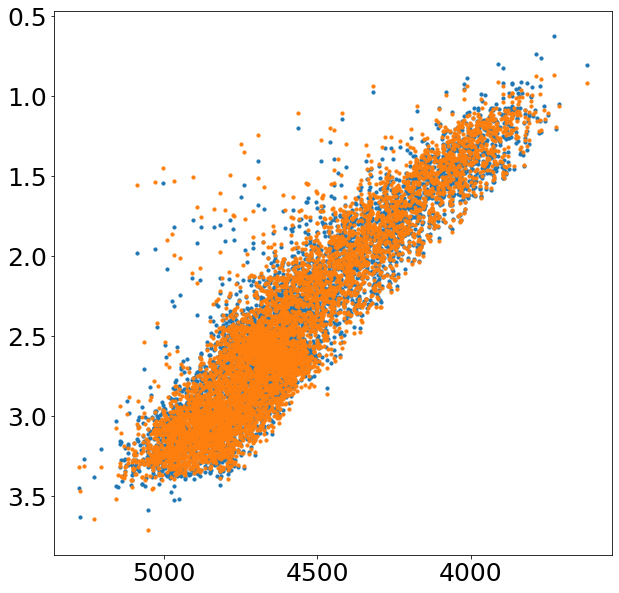

In [90]:
plt.figure(figsize=[10,10])
plt.scatter(kdr17['TEFF'],kdr17['LOGG'],s=10)
plt.scatter(kdr17['TEFF'],logg_cal_falpha,s=10)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

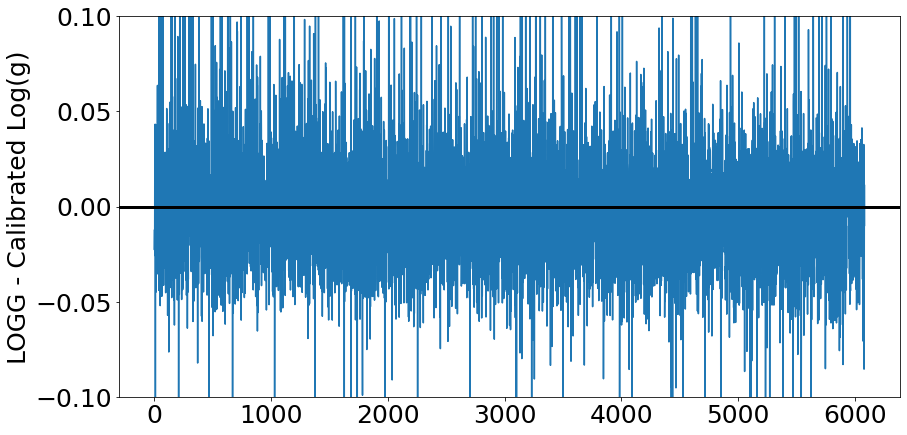

In [93]:
plt.figure(figsize=[14,7])
plt.plot(kdr17['LOGG']-logg_cal_falpha)
plt.axhline(0,c='k',lw=3.0)
plt.ylim(-0.1,0.1)
plt.ylabel('LOGG - Calibrated Log(g)')
plt.show()

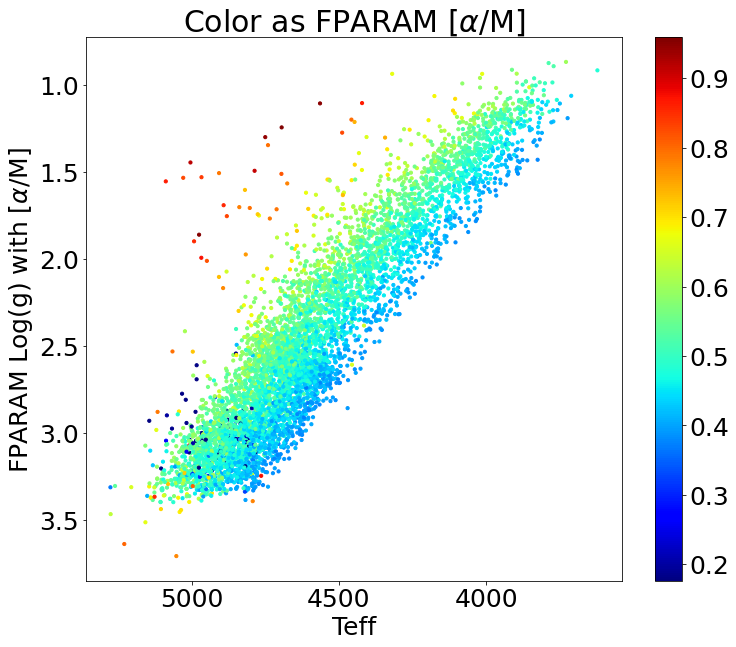

In [108]:
plt.figure(figsize=[12,10])
# plt.scatter(10**massive['logTe'],massive['logg'],c='k')
# plt.xlim(3000,5570)
plt.scatter(kdr17['TEFF'],logg_cal_falpha,c=kdr17['FPARAM'][:,-2],s=10,cmap='jet')
plt.colorbar()

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.title(r'Color as FPARAM [$\alpha$/M]')
plt.xlabel(r'Teff')
plt.ylabel(r'FPARAM Log(g) with [$\alpha$/M]')
plt.show()

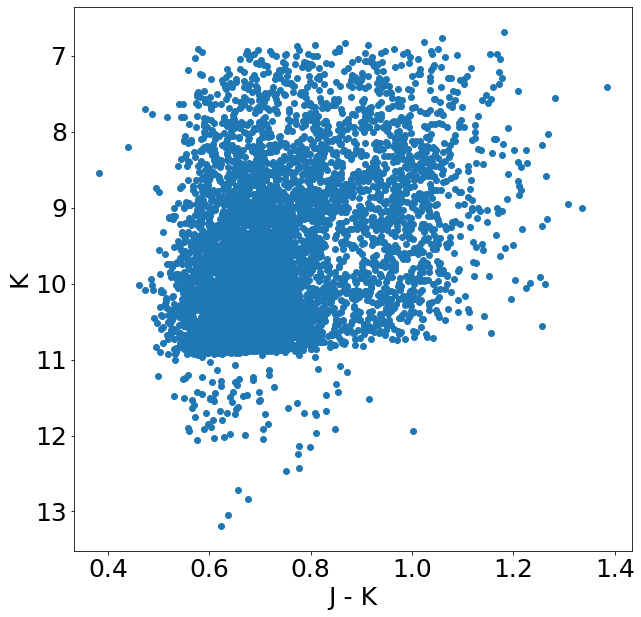

In [109]:
plt.figure(figsize=[10,10])
plt.scatter(kdr17['J']-kdr17['K'],kdr17['K'])
plt.gca().invert_yaxis()

plt.xlabel(r'J - K')
plt.ylabel(r'K')
plt.show()